<a href="https://colab.research.google.com/github/danterocha/danterocha/blob/main/CTP2_atividade_03_%5BDante%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <div align="center"> CTP2 - Atividade Prática 03 </div>

# <div align="center"> ***Dante Rocha Lomonaco - Outubro / 2021*** </div>

<img src=https://jornal.usp.br/wp-content/uploads/2020/06/20200608_oceano_1130px.jpg alt="drawing" style="width:200px;"/>

Material provided by EarthLab under [CC BY-NC-ND 4.0](https://www.earthdatascience.org/license/)  
[Copyright (c) Earth Lab](https://www.earthdatascience.org)

## Preparação

Você pode resolver da forma que desejar. Entretanto, deixo aqui abaixo sugestões de bibliotecas que instalei para resolver essa atividade.

In [1]:
!pip install pandas fiona shapely pyproj rtree
!pip install rioxarray
!pip install earthpy
!pip install geopandas
!pip install metpy
!pip install matplotlib-venn
!pip install pygeos
#!pip install cartopy
#!pip install rtree

     |████████████████████████████████| 15.4 MB 35 kB/s 
     |████████████████████████████████| 6.3 MB 35.3 MB/s 
     |████████████████████████████████| 994 kB 35.0 MB/s 
     |████████████████████████████████| 46 kB 2.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.1 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.7.1-py3-none-any.whl size=54118 sha256=8c0129114cb2702e99e3972135f1d5d02161ad2143d98736696db4995193ee58
  Stored in directory: /root/.cache/pip/wheels/42/9b/1c/acf2904f7ee44be3c0b8ffc7ea4fafebb135aee00242bef86f
Successfully built rioxarray
     |████████████████████████████████| 1.4 MB 6.6 MB/s 
     |████████████████████████████████| 1.0 MB 58.5 MB/s 
     |████████████████████████████████| 361 kB 6.4 MB/s 
     |████████████████████████████████| 204 kB 56.4 MB/s 
     |████████████████████████████████| 1.8 MB 6.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# your path preffix
my_path = 'Colab Notebooks/CTP2-Atividade3/'
my_path = '/content/drive/MyDrive/' + my_path
my_path

'/content/drive/MyDrive/Colab Notebooks/CTP2-Atividade3/'

# Parte 2 - dados climáticos em netCDF4

Os dados necessários estão [aqui](https://drive.google.com/open?id=15wY9s7_YVC5eFDrmhYOfwyNTOh348Y8N&authuser=lmiquelutti%40id.uff.br&usp=drive_fs).

**O CRS do dado é WGS84/WGS84 - código EPSG:4326.**

Comece importando as bibliotecas necessárias (abaixo sugestões).

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import seaborn as sns
import geopandas as gpd
import pydot
#import cartopy
import pygeos
#import rtree
import os
import pandas as pd
import urllib.request
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import shutil
import earthpy as et

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
# read netCDF4 file
data_path = my_path + 'uvt_2019.nc'
# Open the data using a context manager
with xr.open_dataset(data_path) as file_nc:
    uvt_2019 = file_nc.rio.write_crs(4326)

# View xarray object
uvt_2019

<xarray.Dataset>
Dimensions:      (latitude: 721, level: 4, longitude: 1440, time: 12)
Coordinates:
  * longitude    (longitude) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude     (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level        (level) int32 250 500 850 1000
  * time         (time) datetime64[ns] 2019-12-29 ... 2019-12-31T18:00:00
    spatial_ref  int64 0
Data variables:
    t            (time, level, latitude, longitude) float32 ...
    u            (time, level, latitude, longitude) float32 ...
    v            (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-22 13:19:59 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [6]:
# Need to convert longitudes?
uvt_2019.coords['longitude'] = ((uvt_2019.coords['longitude'] + 180) % 360) - 180
uvt_2019 = uvt_2019.sortby(uvt_2019.longitude)
uvt_2019.coords['longitude'].attrs['units'] = 'degrees_east'
uvt_2019.coords['longitude'].attrs['long_name'] = 'longitude'

#Convert tempeature to Celsius
uvt_2019['t'] = uvt_2019['t']-273
uvt_2019['t'].attrs['units'] = '°C'
uvt_2019['t'].attrs['long_name'] = 'temperature'

In [7]:
uvt_2019

<xarray.Dataset>
Dimensions:      (latitude: 721, level: 4, longitude: 1440, time: 12)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude     (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level        (level) int32 250 500 850 1000
  * time         (time) datetime64[ns] 2019-12-29 ... 2019-12-31T18:00:00
    spatial_ref  int64 0
Data variables:
    t            (time, level, latitude, longitude) float32 -64.52 ... -8.445
    u            (time, level, latitude, longitude) float32 ...
    v            (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-22 13:19:59 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [8]:
# extract the variables (make things easier)
# u = ds['u']
longitude = uvt_2019['longitude'].values
latitude = uvt_2019['latitude'].values

In [9]:
# View min/max latitude and longitudes values
print("The min and max latitude values in the data is:",
      latitude.min(), 
      latitude.max())
print("The min and max longitude values in the data is:",
      longitude.min(), 
      longitude.max())

The min and max latitude values in the data is: -90.0 90.0
The min and max longitude values in the data is: -180.0 179.75


In [10]:
# View date range
t_min = uvt_2019['t']['time'].values.min()
t_max = uvt_2019['t']['time'].values.max()

print("The earliest date in the data is:",t_min )
print("The latest date in the data is:", t_max)   

The earliest date in the data is: 2019-12-29T00:00:00.000000000
The latest date in the data is: 2019-12-31T18:00:00.000000000


In [11]:
# check the shape
uvt_2019['t']['time'].shape

(12,)

In [12]:
# View metadata
metadata = uvt_2019.attrs
metadata

{'Conventions': 'CF-1.6',
 'history': '2020-01-22 13:19:59 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -o /cache/data8/adaptor.mars.internal-1579699187.4853168-29523-5-313b63fc-f4b1-47ca-b811-10287735ac16.nc /cache/tmp/313b63fc-f4b1-47ca-b811-10287735ac16-adaptor.mars.internal-1579699187.4857779-29523-3-tmp.grib'}

In [13]:
# set the data CRS
# The data are lat/long (not projected)
uvt_2019.rio.crs

CRS.from_epsg(4326)

## Questão 1 - gerando um mapa global com os dados de temperatura

In [14]:
# Select the data
temp = uvt_2019['t'].sel(time = t_min, level = 850)

In [15]:
temp

<xarray.DataArray 't' (latitude: 721, longitude: 1440)>
array([[-21.05664  , -21.05664  , -21.05664  , ..., -21.05664  ,
        -21.05664  , -21.05664  ],
       [-21.317108 , -21.317108 , -21.317108 , ..., -21.32071  ,
        -21.32071  , -21.32071  ],
       [-21.644043 , -21.642258 , -21.640457 , ..., -21.647644 ,
        -21.645844 , -21.645844 ],
       ...,
       [-15.168243 , -15.168243 , -15.168243 , ..., -15.1718445,
        -15.170044 , -15.170044 ],
       [-15.1718445, -15.1718445, -15.1718445, ..., -15.173645 ,
        -15.1718445, -15.1718445],
       [-15.211365 , -15.211365 , -15.211365 , ..., -15.211365 ,
        -15.211365 , -15.211365 ]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude     (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    level        int32 850
    time         datetime64[ns] 2019-12-29
    spatial_ref  int64 0
Attributes:
    units:      °C
    long_name:  temperature

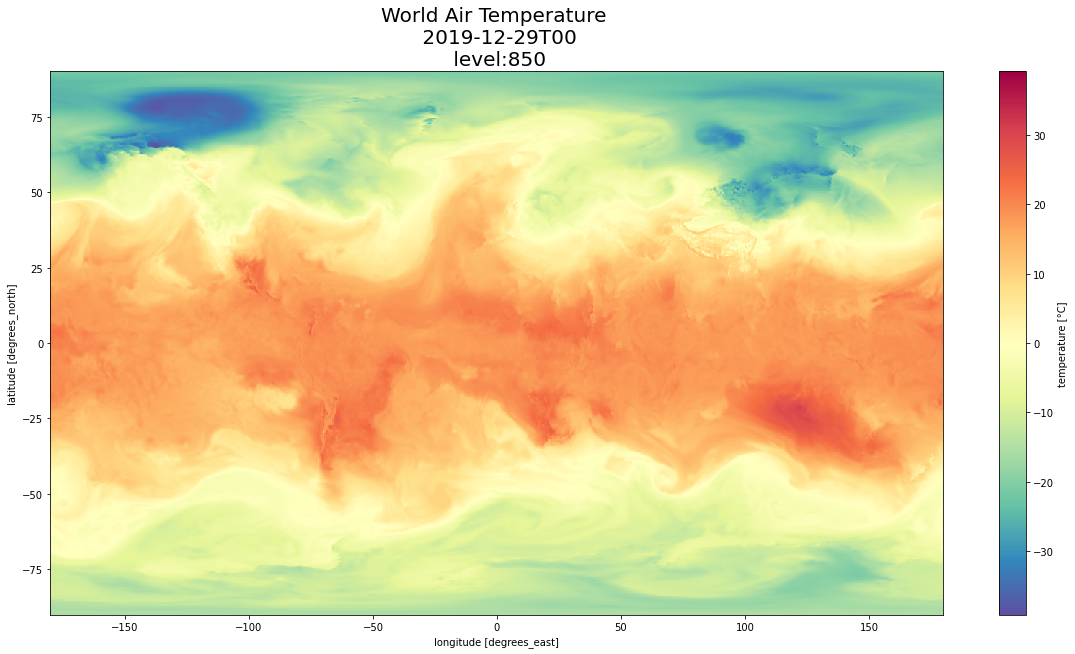

In [16]:
# Quickly plot the data using xarray.plot()

# Plot the data
f, ax = plt.subplots(figsize=(20, 10))

temp.plot(cmap = 'Spectral_r')

tit= ('World Air Temperature \n '+ str(np.datetime64(temp.time.values,'h')) +'\n level:'+ str(temp.level.values))
ax.set_title(tit, fontsize=20)

plt.show()

A célula abaixo baixa o shapefile das linhas costeiras. Use-o para plotar o mapa de temperatura global junto com os continentes.

In [17]:
# Download natural earth data which contains state boundaries to generate AOI
url ='https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip'
source_folder = et.data.get_data(url = url)

destination_folder = os.path.join(my_path,'data',source_folder.split('/')[-1])
shutil.rmtree(destination_folder)
shutil.copytree(source_folder, destination_folder)

for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)
        print('copied', file_name)

Extracted output to /root/earth-analytics/data/earthpy-downloads/ne_110m_coastline


Leia e plote o `shapefile` para conferir se ele mostra o mundo todo.

In [18]:
# read shapefile
countries_path = os.path.join(destination_folder,
                           "ne_110m_coastline.shp")
countries = gpd.read_file(countries_path)

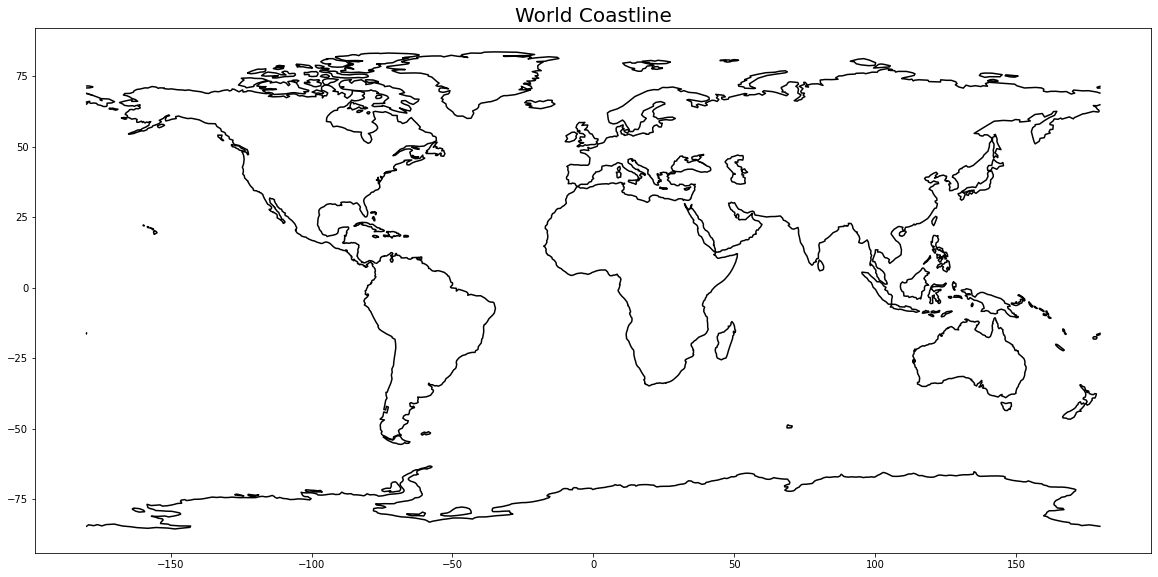

In [19]:
# plot it
f, ax = plt.subplots(figsize=(20, 10))

countries.plot(color='black',
           alpha=1,
           ax=ax)

tit= ('World Coastline')
ax.set_title(tit, fontsize=20)

plt.show()

Crie um plot da distribuição global de temperatura para `time = 0` e `level = 3` com os continentes ao fundo do mapa. Seu resultado deve se parecer com a figura abaixo.

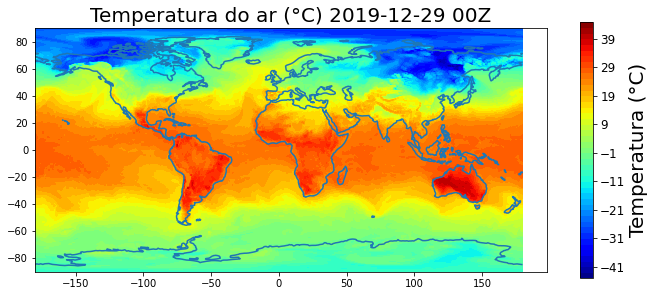

In [20]:
#df1.index = df1.index.strftime('%Y-%m-%d')
#tttt = temp.time.values

tttt = np.datetime64(temp.time.values,'m')
tttt

numpy.datetime64('2019-12-29T00:00')

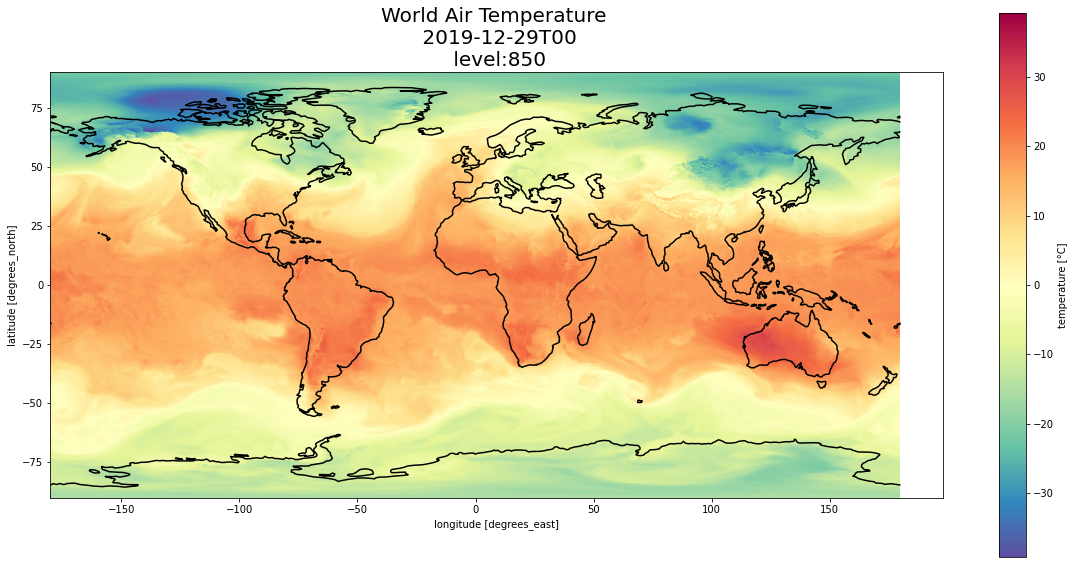

In [21]:
#Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(20, 10))

#Criando um eixo
ax = fig.add_subplot()

#Plotando a temperatura do ar para o globo todo
#Inserindo uma colorbar
temp.plot.imshow(cmap = 'Spectral_r')

#Adicionando o contorno dos continentes
countries.plot(color='black',
           alpha=1,
           ax=ax)

#Adicionando o título da figura
tit= ('World Air Temperature \n '+ str(np.datetime64(temp.time.values,'h')) +'\n level:'+ str(temp.level.values))
ax.set_title(tit, fontsize=20)

plt.show()


## Questão 2 - gerando um mapa das correntes de ar para a América do Sul

Para esta parte, você deve calcular a **magnitude da velocidade do vento** a partir dos dados presentes no arquivo. Verifique os atributos de cada `data variable` para deduzir quais são as variáveis necessárias para seu cálculo.

In [22]:
# extract the variables (make things easier)
# u = ds['u']
U = uvt_2019['u'].sel(time = t_min, level = 850)
V = uvt_2019['v'].sel(time = t_min, level = 850)

In [23]:
#Criando matrizes de longitude e latitude
lon, lat = np.meshgrid(U.longitude, U.latitude)

In [24]:
# calcute the wind speed (necessary for coloring the arrows)
#calculo velocidade do vento
uvt_2019['w'] = np.sqrt(uvt_2019['v']**2+uvt_2019['u']**2)
W = uvt_2019['w'].sel(time = t_min, level = 850)

Extraia um subset da América do Sul.

In [25]:
#Extraindo um subset dos dados para a América do Sul
from shapely.geometry import Polygon
# Create a custom polygon
polygon = Polygon([(-90,20),(-20,20),(-20,-60),(-90,-60),(-90,20)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=4326)

In [26]:
U_clipped = U.sel(longitude=slice(-90,-20), latitude=slice(20,-60))

V_clipped = V.sel(longitude=slice(-90,-20), latitude=slice(20,-60))

W_clipped = W.sel(longitude=slice(-90,-20), latitude=slice(20,-60))

A célula abaixo baixa o shapefile dos países com estados. Use-o para plotar o mapa das correntes de ar sobre a América do Sul.

In [27]:
# Download natural earth data which contains state boundaries to generate AOI
url = 'https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip'
source_folder = et.data.get_data(url = url)

destination_folder = os.path.join(my_path,'data',source_folder.split('/')[-1])
shutil.rmtree(destination_folder)
shutil.copytree(source_folder, destination_folder)

for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)
        print('copied', file_name)

Extracted output to /root/earth-analytics/data/earthpy-downloads/ne_10m_admin_1_states_provinces_lakes


Leia e plote o `shapefile` (**apenas os contornos dos países/estados**) para conferir se ele mostra o mundo todo.

In [28]:
# read shapefile
states_path = os.path.join(destination_folder,
                           "ne_10m_admin_1_states_provinces_lakes.shp")
states = gpd.read_file(states_path)


In [29]:
# Clip the AOI using GeoPandas clip
states_clipped = gpd.clip(states, poly_gdf)

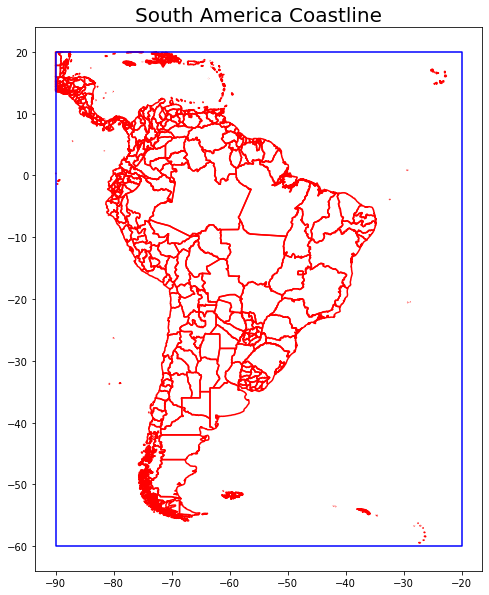

In [30]:
# plot it (just the edges)
f, ax = plt.subplots(figsize=(20, 10))

states_clipped.boundary.plot(ax=ax, color="red")
poly_gdf.boundary.plot(ax=ax, color="blue")
tit= ('South America Coastline')
ax.set_title(tit, fontsize=20)

plt.show()

Faça um plot das correntes de ar. Para tal, use a função [`streamplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.streamplot.html). Novamente, use:
* `time = 0`
* `level = 3`

Seu resultado deve se parecer com a imagem abaixo. 

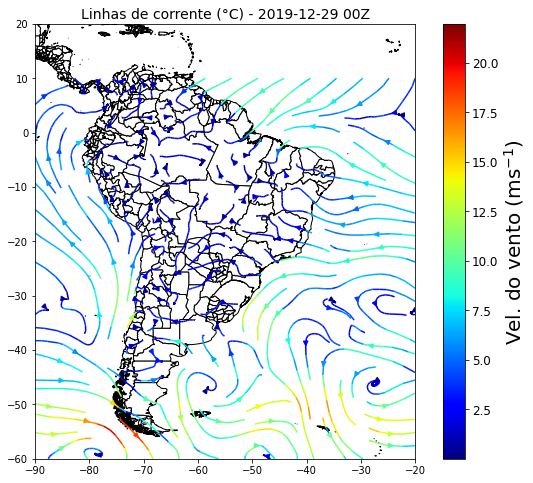

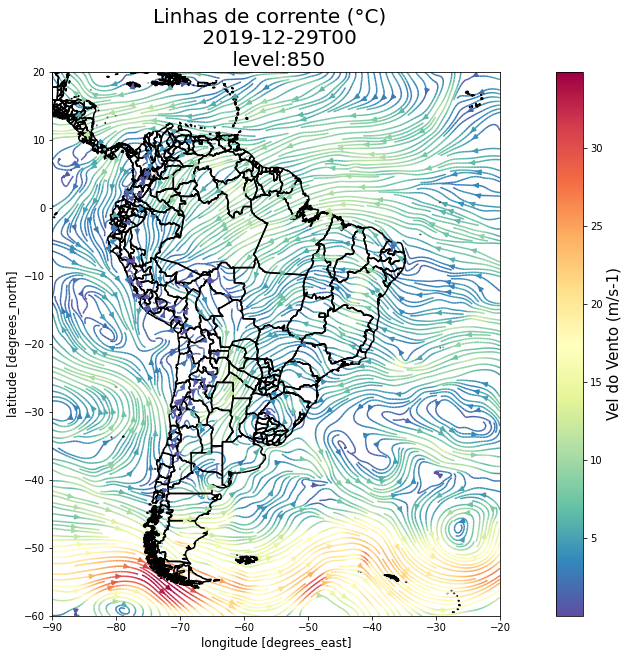

In [31]:
#Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(20, 10))

#Criando um eixo com uma determinada projeção
ax = fig.add_subplot()

#Criando matrizes de longitude e latitude
lon, lat = np.meshgrid(U_clipped.longitude, V_clipped.latitude)

#Definindo a extensão do mapa
xlim = (-90,  -20)
ylim = (-60,  20)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#Plotando as linhas de corrente e a intensidade do vento
#matplotlib.pyplot.streamplot(x, y, u, v, density=1, linewidth=None,
#                             color=None, cmap=None, norm=None, arrowsize=1,
#                             arrowstyle='-|>', minlength=0.1, transform=None,
#                             zorder=None, start_points=None, maxlength=4.0,
#                             integration_direction='both', *, data=None)[source]


h = ax.streamplot(lon, lat, U_clipped, V_clipped, density = 5, color=W_clipped.values, cmap='Spectral_r')

# plotando o shapefile - contornos apenas
states_clipped.boundary.plot(ax=ax, color='black')

#Inserindo uma colorbar
cbar = fig.colorbar(h.lines, ax=ax)

cbar.set_label('Vel do Vento (m/s-1)', fontsize=15)

#Adicionando o título da figura
tit = ('Linhas de corrente (°C)  \n '+ str(np.datetime64(temp.time.values,'h'))+'\n level:'+ str(temp.level.values))
ax.set_title(tit, fontsize=20)

ax.set_xlabel('longitude [degrees_east]', fontsize=12)
ax.set_ylabel('latitude [degrees_north]', fontsize=12)


plt.show()

# Parte 2 - dados MODIS via RESTful API

Nessa parte, você deve responder questões relacionadas à **cidade** do Rio de Janeiro. Para isso, baixe os dados utilizando a API para pegar dados MODIS.



In [32]:
import requests
import json
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'} # Use following for a csv response: header = {'Accept': 'text/csv'}

## Questão 1 - Selecionar:
* o ponto central
* `kmAboveBelow`
* `kmLeftRight`  

e explicar a escolha desses parâmetros em relação ao local que deseja investigar. Quais critérios o levou a decidir pelos parâmetros que escolheu?



In [33]:
lat = -22.88430459554137 # Input latitude
lon = -43.13333068097053 # Input longitude
prod = 'MOD11A2' # MODIS product
data_band = 'LST_Day_1km' # Daytime LST band name
qc_band = 'QC_Day' # Daytime QC band name

above_below = 10 # km above/below
left_right = 10 # km left/right

In [34]:
response = requests.get('https://modis.ornl.gov/rst/api/v1/MOD11A2/dates?latitude=-22.88430459554137&longitude=-43.13333068097053', headers=header)
dates = json.loads(response.text)['dates']

In [35]:
# get modis dates
modis_dates = [i['modis_date'] for i in dates]

In [36]:
# get list of 3-years dates
# Take three years of dates beginning with A2001001 : 46 * 3 = 138 dates
dates = modis_dates[modis_dates.index('A2000049'):modis_dates.index('A2000049') + 459]

In [37]:
# We will loop through the list of dates and submit requests for both the daytime LST (LST_Day_1km) and daytime QC layers (QC_Day).
######################################
# This may take several minutes!!
######################################
# Initialize lists to store the returned LST and QC data
lstdata = []
qcdata = []

# Iterate through the list of dates and submit subset requests for each date:
for dt in dates:
    
    # Join LST request parameters to URL string and submit request
    lstresponse = requests.get("".join([
        url, prod, "/subset?",
        "latitude=", str(lat),
        "&longitude=", str(lon),
        "&band=", data_band,
        "&startDate=", dt,
        "&endDate=", dt,
        "&kmAboveBelow=", str(above_below),
        "&kmLeftRight=", str(left_right)
    ]), headers=header)

    # Append subset data to lstdata
    lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )
        
    # Join QC request parameters to URL string and submit request
    qcresponse = requests.get("".join([
        url, prod, "/subset?",
        "latitude=", str(lat),
        "&longitude=", str(lon),
        "&band=", qc_band,
        "&startDate=", dt,
        "&endDate=", dt,
        "&kmAboveBelow=", str(above_below),
        "&kmLeftRight=", str(left_right)
    ]), headers=header)
    
    # Append qc data to qcdata
    qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )

In [38]:
# Convert to real dates
dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

In [39]:
# create dataframes for lstdata and qcdata
lstdata = pd.DataFrame(lstdata, index = dates)
qcdata = pd.DataFrame(qcdata, index = dates)

In [40]:
# get unique values from qcvals
qcvals = pd.unique(qcdata.values.ravel())
qcvals

array([  2,   3,  17,   0,  65,  81, 145, 129])

In [41]:
qcdata.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440
2010-01-18,65,65,65,3,3,3,3,3,3,3,3,3,3,3,3,81,81,81,81,81,81,65,65,65,3,3,3,3,3,3,3,3,3,3,3,2,81,81,81,81,...,65,65,65,65,65,65,65,65,3,3,3,3,3,3,3,3,3,3,3,0,65,65,65,65,65,65,65,3,3,3,3,3,3,3,3,3,3,3,3,3
2010-01-26,81,0,0,3,3,3,3,3,3,3,3,3,3,3,3,81,65,65,81,81,81,65,81,17,3,3,3,3,3,3,3,3,3,3,3,0,0,81,81,81,...,65,65,65,65,65,0,65,2,3,3,3,3,3,3,3,3,3,3,3,65,65,65,65,65,65,65,65,3,3,3,3,3,3,3,3,3,3,3,3,3
2010-02-03,17,0,0,3,3,3,3,3,3,3,3,3,3,3,3,0,81,81,81,81,81,0,0,0,3,3,3,3,3,3,3,3,3,3,3,0,65,81,81,81,...,0,0,0,0,81,0,0,0,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3
2010-02-11,65,65,65,3,3,3,3,3,3,3,3,3,3,3,3,0,81,81,81,81,81,81,65,65,3,3,3,3,3,3,3,3,3,3,3,65,65,81,81,81,...,0,0,0,0,65,65,65,65,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3
2010-02-19,81,65,65,3,3,3,3,3,3,3,3,3,3,3,3,17,17,81,81,81,81,0,65,65,3,3,3,3,3,3,3,3,3,3,3,0,0,81,81,81,...,65,0,0,0,65,65,65,65,3,3,3,3,3,3,3,3,3,3,3,65,65,65,65,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3


In [42]:
for integer in range(0, 5, 1):
    print(list(map(int, list("{0:b}".format(integer).zfill(8)))))

[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 1, 0, 0]


In [43]:
# Create empty list to store QC bit information
QC_Data = []

# Iterate through the list of 8-bit integers and populate QC table with bit definitions 
for integer in range(0, 256, 1):
    bits = list(map(int, list("{0:b}".format(integer).zfill(8))))
    
    # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
    # Mandatory_QA bits description
    if (bits[6] == 0 and bits[7] == 0):
        Mandatory_QA = 'LST GOOD'
    if (bits[6] == 0 and bits[7] == 1):
        Mandatory_QA = 'LST Produced,Other Quality'
    if (bits[6] == 1 and bits[7] == 0):
        Mandatory_QA = 'No Pixel,clouds'
    if (bits[6] == 1 and bits[7] == 1):
        Mandatory_QA = 'No Pixel, Other QA'
        
    # Data_Quality bits description
    if (bits[4] == 0 and bits[5] == 0):
        Data_Quality = 'Good Data'
    if (bits[4] == 0 and bits[5] == 1):
        Data_Quality = 'Other Quality'
    if (bits[4] == 1 and bits[5] == 0):
        Data_Quality = 'TBD'
    if (bits[4] == 1 and bits[5] == 1):
        Data_Quality = 'TBD'
        
    # Emiss_Err bits description
    if (bits[2] == 0 and bits[3] == 0):
        Emiss_Err = 'Emiss Err <= .01'
    if (bits[2] == 0 and bits[3] == 1):
        Emiss_Err = 'Emiss Err <= .02'
    if (bits[2] == 1 and bits[3] == 0):
        Emiss_Err = 'Emiss Err <= .04'
    if (bits[2] == 1 and bits[3] == 1):
        Emiss_Err = 'Emiss Err > .04'
        
    # LST_Err bits description
    if (bits[0] == 0 and bits[1] == 0):
        LST_Err = 'LST Err <= 1K'
    if (bits[0] == 0 and bits[1] == 1):
        LST_Err = 'LST Err <= 3K'
    if (bits[0] == 1 and bits[1] == 0):
        LST_Err = 'LST Err <= 2K'
    if (bits[0] == 1 and bits[1] == 1):
        LST_Err = 'LST Err > 3K' 
    
    # Append this integers bit values and descriptions to list
    QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])
    
# Convert QC bits and descriptions to pandas data frame
QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
1,1,0,0,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
4,4,0,0,0,0,0,1,0,0,LST GOOD,Other Quality,Emiss Err <= .01,LST Err <= 1K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,1,1,1,1,1,0,1,1,"No Pixel, Other QA",TBD,Emiss Err > .04,LST Err > 3K
252,252,1,1,1,1,1,1,0,0,LST GOOD,TBD,Emiss Err > .04,LST Err > 3K
253,253,1,1,1,1,1,1,0,1,"LST Produced,Other Quality",TBD,Emiss Err > .04,LST Err > 3K
254,254,1,1,1,1,1,1,1,0,"No Pixel,clouds",TBD,Emiss Err > .04,LST Err > 3K


In [44]:
# remove the rows for values that aren't in our subset
QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
17,17,0,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 1K
65,65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 3K
81,81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 3K
129,129,1,0,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 2K
145,145,1,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 2K


In [45]:
# filter for conditions above
QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) |
                      ( (QC_Data['Bit0'] == 1) &
                        (QC_Data['Bit1'] == 0) &
                        (QC_Data['Bit6'] != 0) )]
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
65,65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 3K
81,81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 3K


In [46]:
# create list of values to be masked
filter = QC_Data['Integer_Value'].tolist()

In [47]:
# mask the data
lstdata_filt = lstdata.mask(qcdata.isin(filter))
lstdata_filt.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440
2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15092.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-26,NaN,15355.0,15310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15295.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15241.0,15312.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-03,15594.0,15610.0,15581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15454.0,NaN,NaN,NaN,NaN,NaN,15565.0,15595.0,15554.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15411.0,NaN,NaN,NaN,NaN,...,15296.0,15328.0,15359.0,15365.0,NaN,15432.0,15416.0,15372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15233.0,15266.0,15312.0,15365.0,15386.0,15351.0,15355.0,15388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15261.0,15294.0,15304.0,15293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15184.0,15217.0,15285.0,15336.0,15340.0,15306.0,15236.0,15293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15412.0,15429.0,NaN,NaN,NaN,NaN,15333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15414.0,15341.0,NaN,NaN,NaN,...,NaN,15241.0,15256.0,15255.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15358.0,15247.0,15242.0,15278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# get scale factor and apply to data
scale = 0.02 #json.loads(response.text)['scale']
lstdata_filt_scale = lstdata_filt*float(scale)

In [49]:
# get nrows and ncols for quality control
ncol = int(json.loads(lstresponse.text)['ncols'])
nrow = int(json.loads(lstresponse.text)['nrows'])
ncol, nrow

(21, 21)

In [50]:
# create a new dataframe for lst stats (mean - std - quality)
lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis = 1),
                        lstdata_filt_scale.std(axis = 1),
                        lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]),
                        columns = ['mean', 'std', 'quality'],
                        index = dates)

# converting dataframe index to date time
lststats.index = pd.to_datetime(lststats.index)

lststats['date'] = lststats.index


lststats

,mean,std,quality,date
2000-02-19,NaN,NaN,0.000000,2000-02-19
2000-02-27,304.731042,2.772464,21.768707,2000-02-27
2000-03-06,305.009333,4.969035,3.401361,2000-03-06
2000-03-14,300.273125,1.144700,7.256236,2000-03-14
2000-03-22,304.254012,2.557979,37.868481,2000-03-22
...,...,...,...,...
2010-01-18,306.155000,3.133118,1.814059,2010-01-18
2010-01-26,305.310370,2.895318,12.244898,2010-01-26
2010-02-03,308.789655,2.348698,32.879819,2010-02-03
2010-02-11,308.342951,3.409015,13.832200,2010-02-11


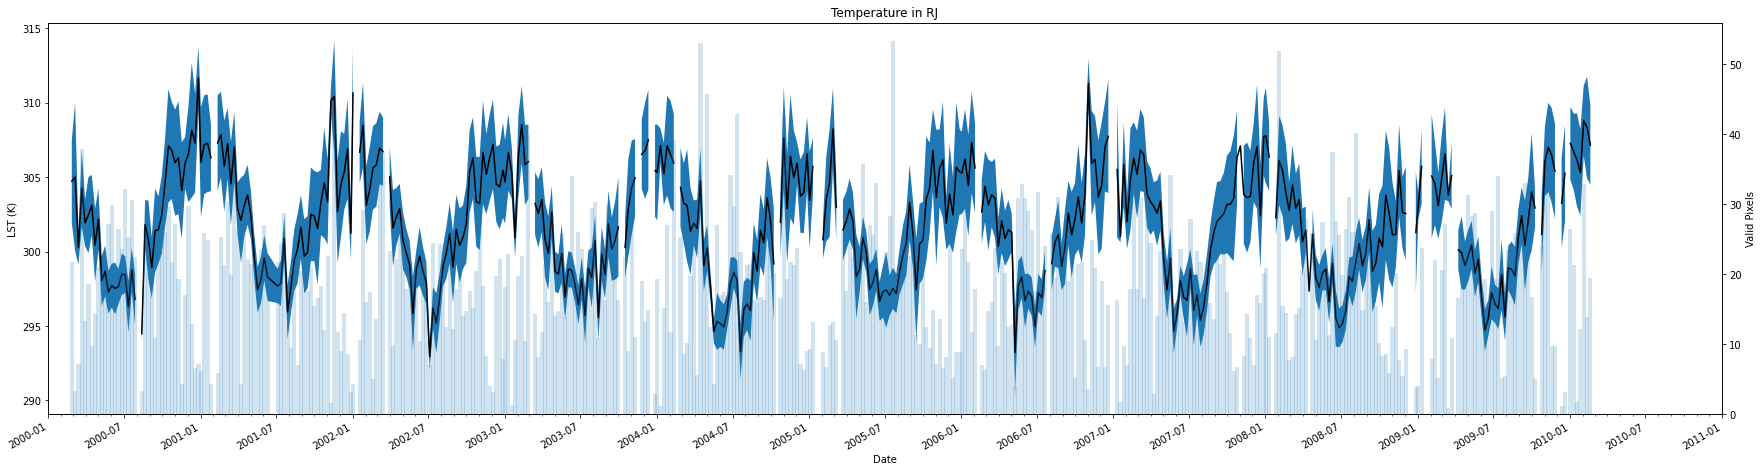

In [51]:
import matplotlib.dates as mdates
# finally, plot
plt.rcParams['figure.figsize'] = (30,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('LST (K)')
ax1.xaxis_date()

ax1.plot(lststats['date'],
         lststats['mean'],
         'k-')

ax1.fill_between(lststats['date'],
                 lststats['mean'] - lststats['std'],
                 lststats['mean'] + lststats['std'])

ax1.tick_params(axis='y')

# now a bar plot with quality
ax2 = ax1.twinx()
ax2.set_ylabel('Valid Pixels')
ax2.bar(lststats['date'],
        lststats['quality'], 10, alpha = 0.2)

ax2.tick_params(axis='y')

# Round to nearest years.
datemin = np.datetime64(lststats['date'][0], 'Y')
datemax = np.datetime64(lststats['date'][-1], 'Y') + np.timedelta64(1, 'Y')
ax1.set_xlim(datemin, datemax)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax1.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.title('Temperature in RJ')

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()



plt.show()

## Questão 2 - Qual o **ano** mais quente e o ano mais frio do Rio de Janeiro?

Para responder a essa questão, plote a série temporal da média anual da temperatura da superfície terrestre para todas as datas disponíveis para o ponto escolhido.

In [52]:
lststats_annual = lststats.resample("Y").mean()

# converting dataframe index to date time
lststats_annual.index = pd.to_datetime(lststats_annual.index, format = '%Y')
lststats_annual.index = lststats_annual.index.strftime('%Y')

lststats_annual

,mean,std,quality
2000,301.998025,2.344143,18.883220
2001,302.879429,2.430775,18.223047
2002,302.356492,2.305286,16.977226
2003,301.706471,2.140428,17.657498
2004,301.285247,2.296912,19.851129
2005,301.499360,2.383050,17.287785
2006,301.919307,2.377727,17.918762
2007,301.921644,2.422414,16.804693
2008,300.786797,2.313844,17.253278
2009,301.346182,2.161086,16.346249


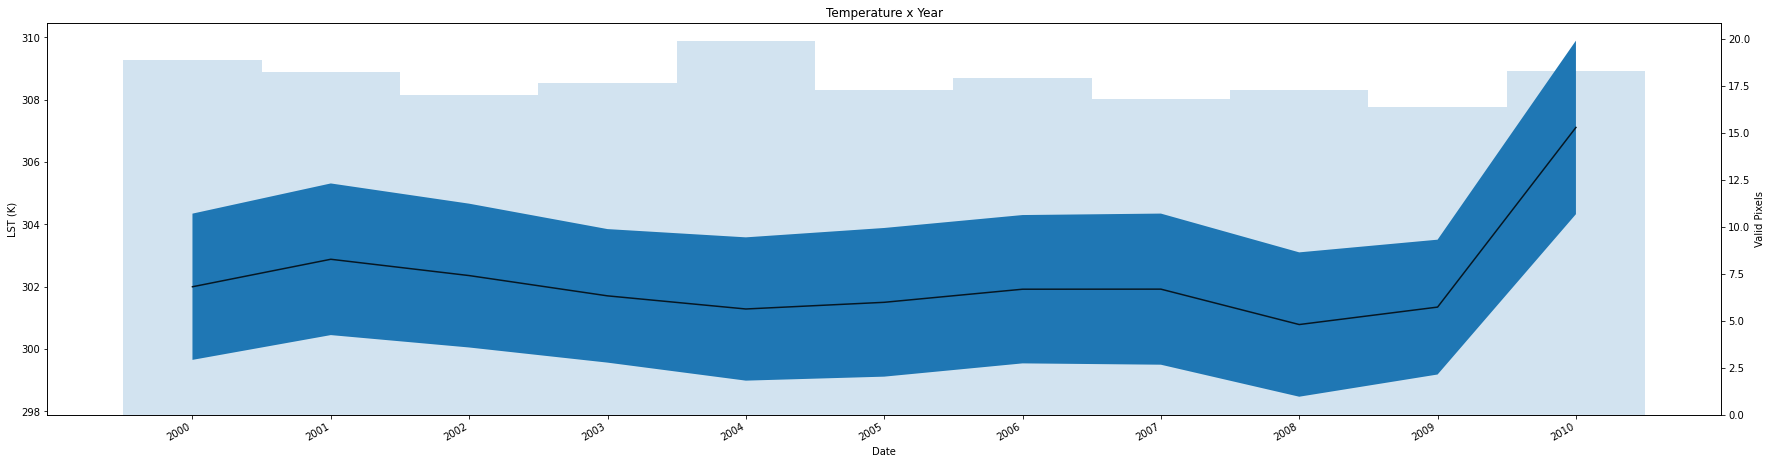

In [53]:
# finally, plot
plt.rcParams['figure.figsize'] = (30,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('LST (K)')
ax1.xaxis_date()

ax1.plot(lststats_annual.index,
         lststats_annual['mean'],
         'k-')

ax1.fill_between(lststats_annual.index,
                 lststats_annual['mean'] - lststats_annual['std'],
                 lststats_annual['mean'] + lststats_annual['std'])

ax1.tick_params(axis='y')

# now a bar plot with quality
ax2 = ax1.twinx()
ax2.set_ylabel('Valid Pixels')
ax2.bar(lststats_annual.index,
        lststats_annual['quality'],1, alpha = 0.2)

ax2.tick_params(axis='y')

plt.title('Temperature x Year')

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.show()

## Questão 3 - Qual a **estação** (e de que ano) mais quente e a mais fria do Rio de Janeiro?

Para responder a essa questão, construa a série temporal da média das estações da temperatura da superfície terrestre para todas as datas disponíveis, e responda qual foi a estação mais quente/fria (e de qual ano) registradas.



In [54]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'autumn': pd.date_range(start='20/03/'+year, end='20/06/'+year),
               'winter': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'spring': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['winter']:
        return 'winter'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'summer'

In [55]:
# create the year data
lststats['year'] = lststats.index.strftime('%Y')

# create the season data
lststats['season'] = lststats.date.map(season_of_date)
lststats

,mean,std,quality,date,year,season
2000-02-19,NaN,NaN,0.000000,2000-02-19,2000,summer
2000-02-27,304.731042,2.772464,21.768707,2000-02-27,2000,summer
2000-03-06,305.009333,4.969035,3.401361,2000-03-06,2000,summer
2000-03-14,300.273125,1.144700,7.256236,2000-03-14,2000,summer
2000-03-22,304.254012,2.557979,37.868481,2000-03-22,2000,autumn
...,...,...,...,...,...,...
2010-01-18,306.155000,3.133118,1.814059,2010-01-18,2010,summer
2010-01-26,305.310370,2.895318,12.244898,2010-01-26,2010,summer
2010-02-03,308.789655,2.348698,32.879819,2010-02-03,2010,summer
2010-02-11,308.342951,3.409015,13.832200,2010-02-11,2010,summer


In [56]:
# Group by season and year
lststats_seasonal = lststats.groupby(['year','season']).mean()

lststats_seasonal 

mean       std    quality
year season                                 
2000 autumn  300.105368  1.869549  20.918367
     spring  305.941103  3.278371  20.614306
     summer  305.419625  2.747962   7.936508
     winter  298.875446  1.780811  19.822373
2001 autumn  301.311604  1.859264  22.737580
     spring  304.812502  3.022095  16.194255
     summer  306.073268  2.867123  15.213358
     winter  299.090512  1.913504  19.002268
2002 autumn  300.412786  1.886002  17.573696
     spring  304.608007  2.822902  15.740741
     summer  306.369155  2.713088  16.058545
     winter  298.196125  1.789169  18.594104
2003 autumn  299.891751  1.746473  18.990930
     spring  303.970122  2.875475  13.926682
     summer  305.310991  2.413398  14.821686
     winter  298.557249  1.720641  23.108637
2004 autumn  298.543158  1.643800  22.203326
     spring  303.880128  3.006869  18.717790
     summer  305.448172  2.828760  15.172129
     winter  298.395832  1.915186  22.826909
2005 autumn  299.766838  1.761526  24.130763
     spring  303.766893  3.197408  12.603930
     summer  304.336915  2.586746   7.586065
     winter  298.852036  2.024541  24.634096
2006 autumn  299.159087  1.847621  21.220711
     spring  304.921181  3.102292  15.098262
     summer  304.767303  2.860389  13.646671
     winter  299.066126  1.709981  21.665636
2007 autumn  299.844076  1.738139  19.784580
     spring  304.377705  3.398913  12.169312
     summer  305.180451  2.628911  15.357658
     winter  298.546193  2.004671  20.057720
2008 autumn  299.058224  1.658537  20.275888
     spring  302.278154  3.364075   8.018965
     summer  304.339510  2.703943  14.491857
     winter  298.436257  1.801785  25.226757
2009 autumn  299.050294  1.641805  19.236584
     spring  304.371695  2.879027  13.718821
     summer  304.597995  2.381401  10.162853
     winter  298.526649  1.867466  22.242837
2010 summer  307.106601  2.781950  18.302559

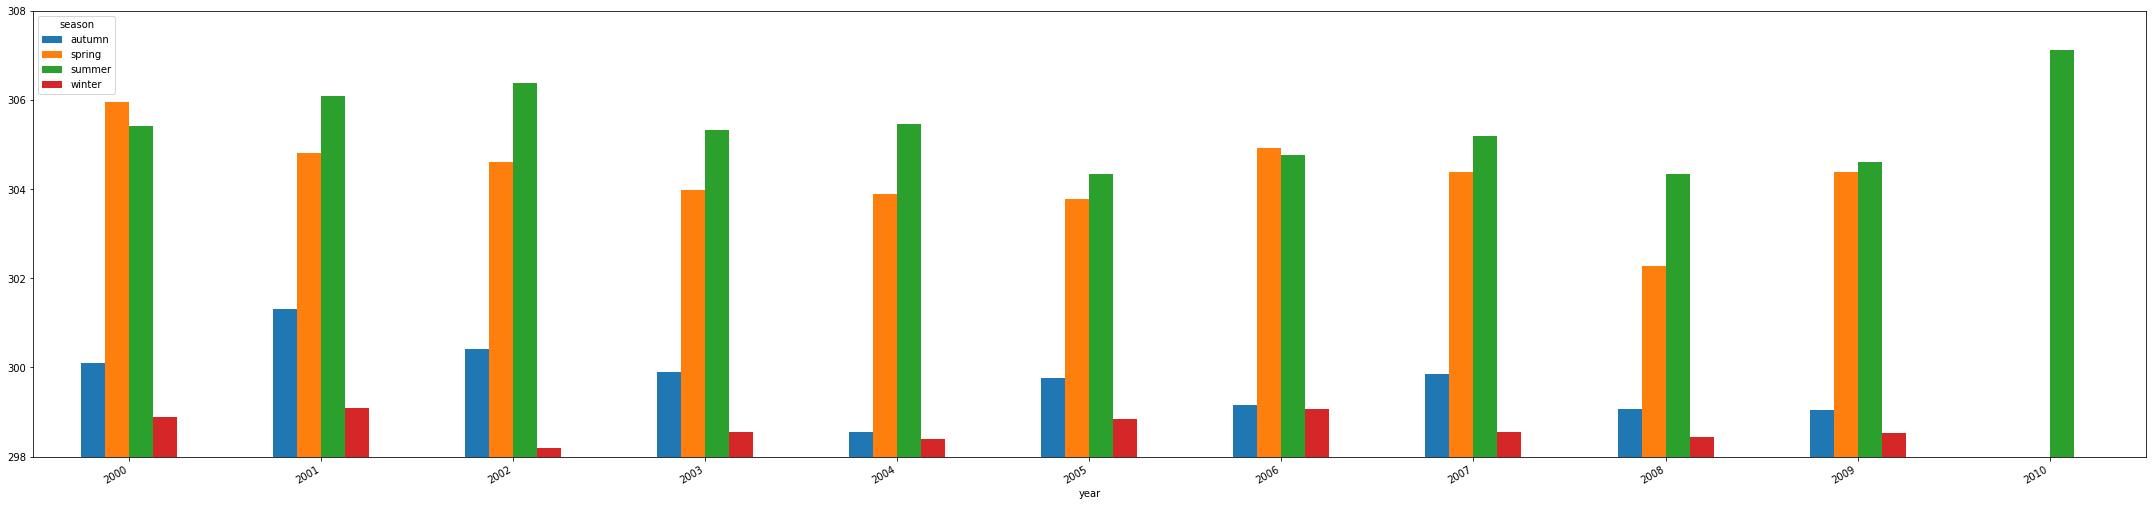

In [65]:
# Plot multi index dataframe

#ax = lststats_seasonal['mean'].unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(30, 10), layout=(2, 6))

lststats_seasonal['mean'].unstack().plot(kind='bar', stacked=False)

plt.gca().set_ylim(298, 308)

plt.tight_layout()

plt.gcf().autofmt_xdate()


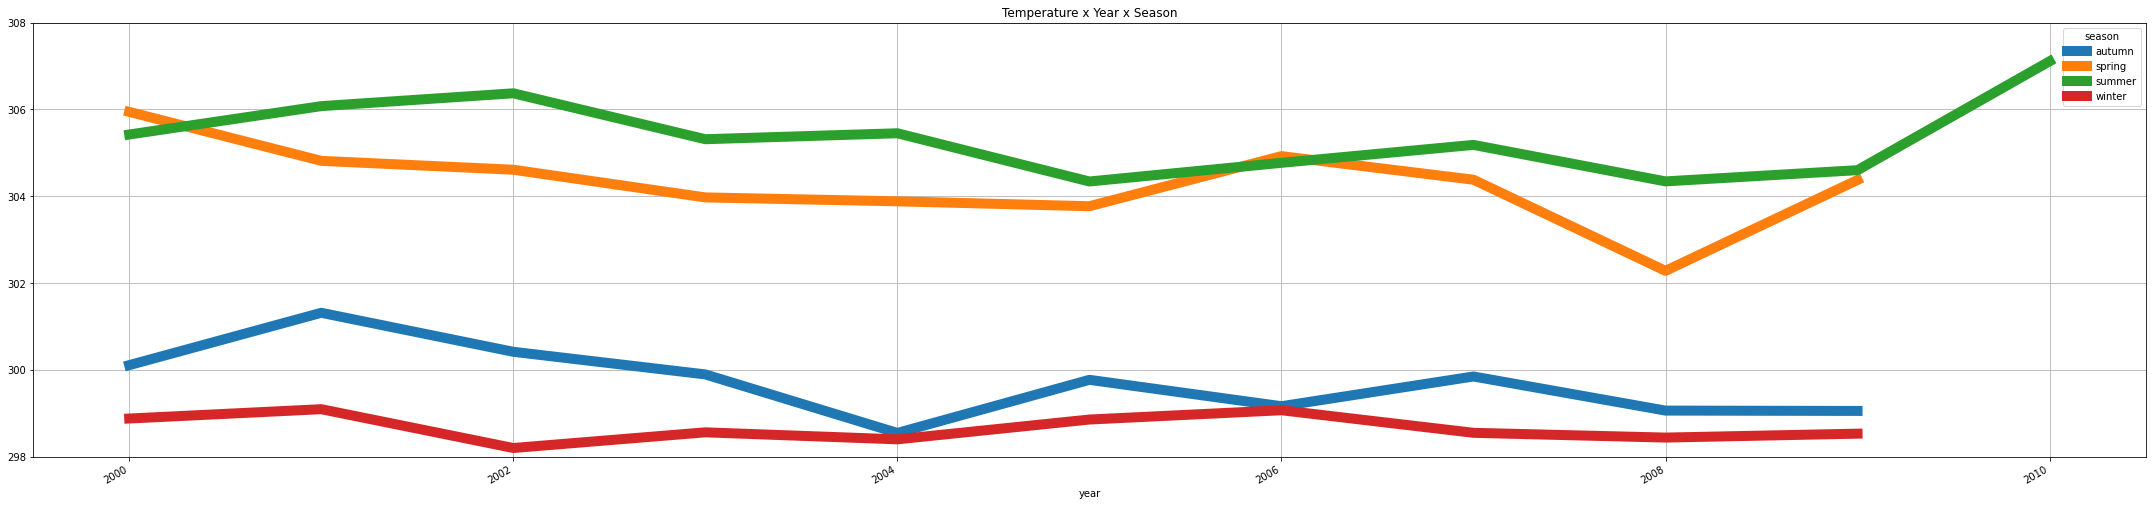

In [76]:
# finally, plot
plt.rcParams['figure.figsize'] = (30,8)

fig, ax3 = plt.subplots()

lststats_seasonal.reset_index().pivot('year','season','mean').plot(ax=ax3, title='Temperature x Year x Season', grid=True, linewidth=10)

plt.gca().set_ylim(298, 308)

plt.tight_layout()

plt.gcf().autofmt_xdate()

## Questão 4 - Qual o **mês** (e de que ano) mais quente e o mais frio do Rio de Janeiro?

Para responder a essa questão, construa a série temporal da média mensal da temperatura da superfície terrestre para todas as datas disponíveis, e responda qual foi o mês mais quente/frio (e de qual ano) registrados.



In [59]:
lststats_monthly = lststats.resample("m").mean()

# converting dataframe index to date time
lststats_monthly.index = pd.to_datetime(lststats_monthly.index, format = '%Y-%m')
lststats_monthly.index = lststats_monthly.index.strftime('%Y-%m')

lststats_monthly

,mean,std,quality
2000-02,304.731042,2.772464,10.884354
2000-03,302.866236,2.561083,15.476190
2000-04,302.002349,2.348597,14.210128
2000-05,299.046922,1.717253,21.371882
2000-06,297.839106,1.443734,23.809524
...,...,...,...
2009-10,302.698183,2.644449,11.451247
2009-11,306.238545,2.940330,21.938776
2009-12,304.263857,3.136466,1.077098
2010-01,306.364040,2.761942,15.476190


In [60]:
# converting dataframe index to date time
lststats_monthly.index = pd.to_datetime(lststats_monthly.index, format = '%Y-%m')

# create the year and month data
lststats_monthly['year'] = lststats_monthly.index.strftime('%Y')

lststats_monthly['month'] = lststats_monthly.index.strftime('%m')


# Group by season and year
lststats_monthly = lststats_monthly.groupby(['year','month']).mean()



lststats_monthly

mean       std    quality
year month                                 
2000 02     304.731042  2.772464  10.884354
     03     302.866236  2.561083  15.476190
     04     302.002349  2.348597  14.210128
     05     299.046922  1.717253  21.371882
     06     297.839106  1.443734  23.809524
...                ...       ...        ...
2009 10     302.698183  2.644449  11.451247
     11     306.238545  2.940330  21.938776
     12     304.263857  3.136466   1.077098
2010 01     306.364040  2.761942  15.476190
     02     308.096683  2.808627  22.071051

[121 rows x 3 columns]

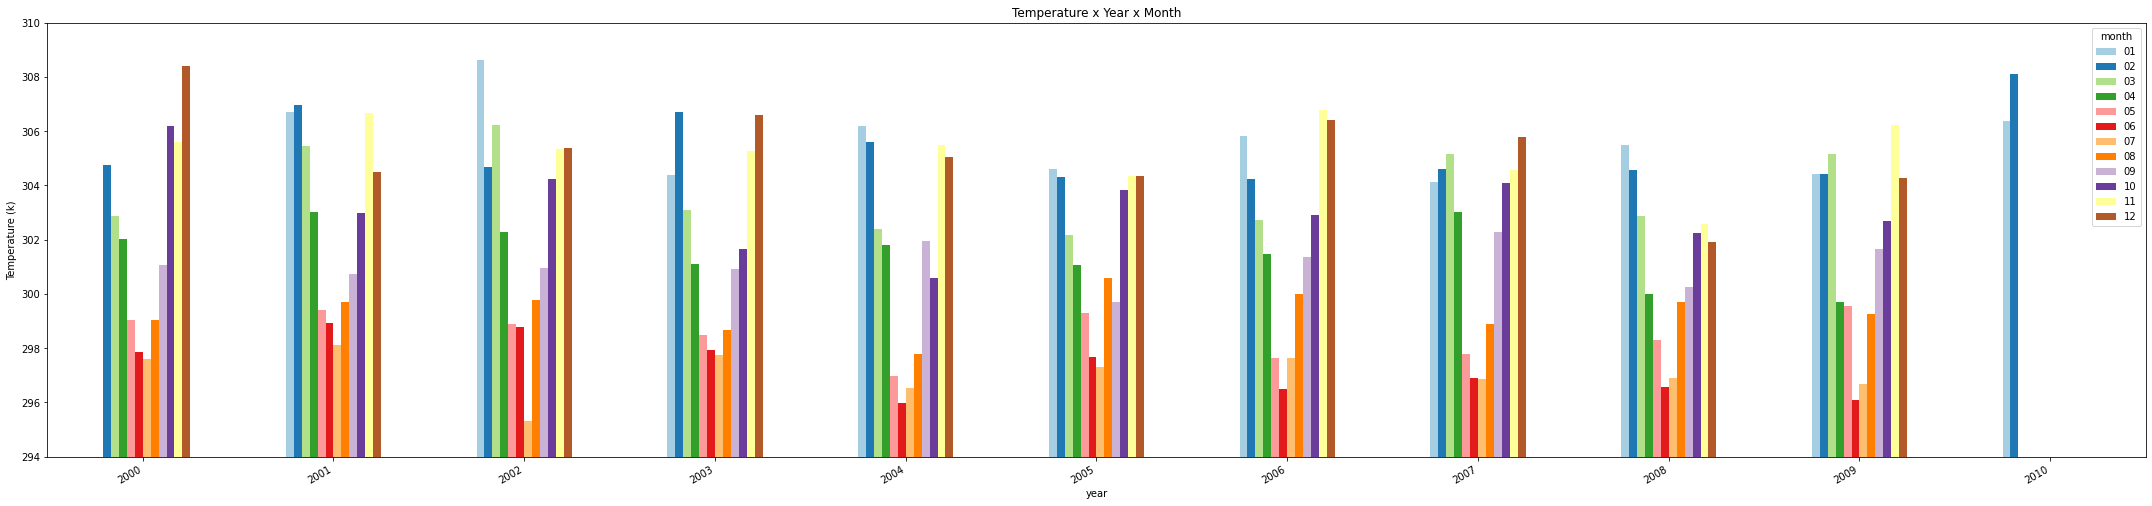

In [75]:
# Plot multi index dataframe
lststats_monthly['mean'].unstack().plot(kind='bar', stacked=False,cmap='Paired')

plt.gca().set_ylim(294, 310)

plt.ylabel('Temperature (k)')

plt.title('Temperature x Year x Month')

plt.tight_layout()

plt.gcf().autofmt_xdate()

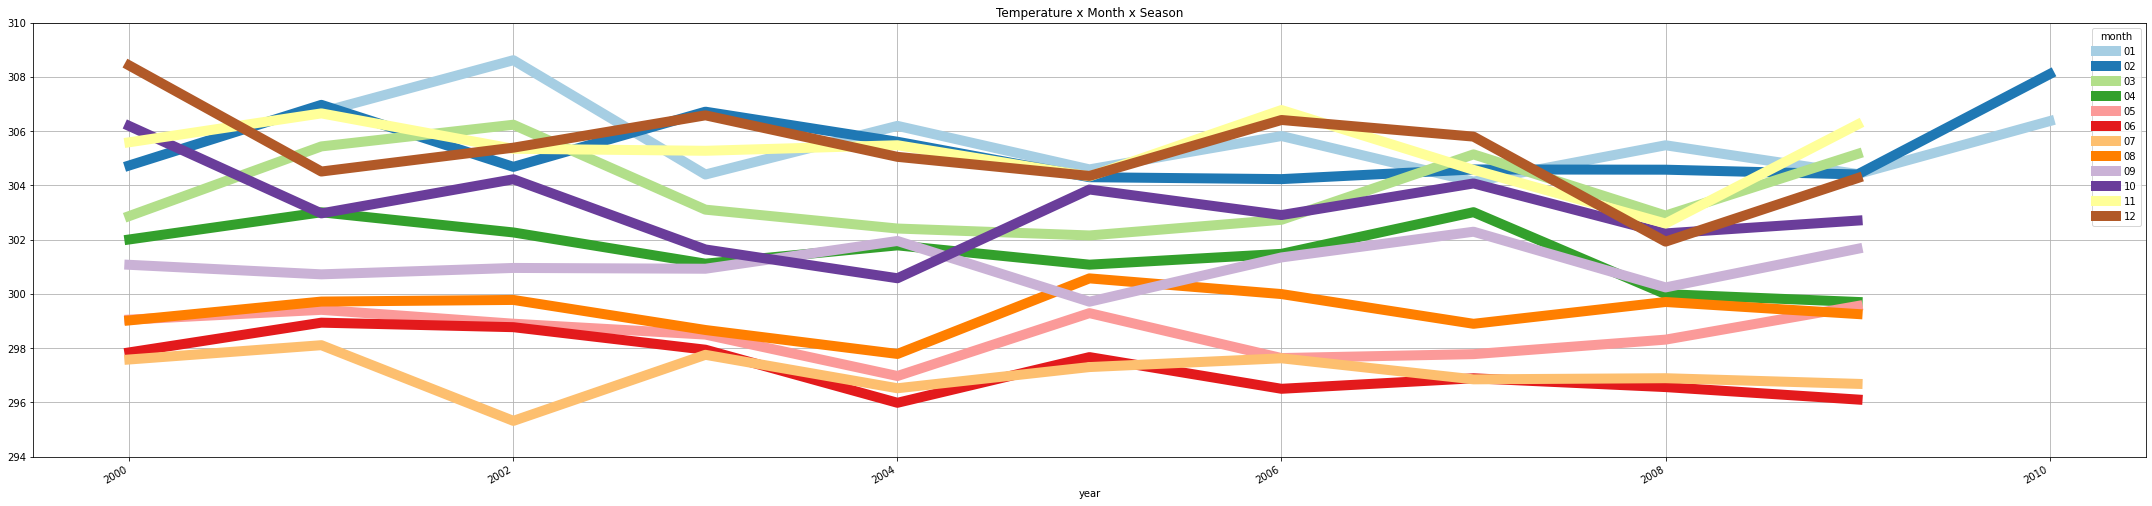

In [74]:
# finally, plot
plt.rcParams['figure.figsize'] = (30,8)

fig, ax3 = plt.subplots()

lststats_monthly.reset_index().pivot('year','month','mean').plot(ax=ax3, title='Temperature x Month x Season', grid=True, linewidth=10,cmap='Paired')

plt.gca().set_ylim(294, 310)

plt.tight_layout()

plt.gcf().autofmt_xdate()

## Questão 5 - Construa as séries temporais das estações do Rio de Janeiro

Nessa questão, construa a série temporal da temperatura para cada uma das estações do ano.

In [85]:
lststats


,mean,std,quality,date,year,season
2000-02-19,NaN,NaN,0.000000,2000-02-19,2000,summer
2000-02-27,304.731042,2.772464,21.768707,2000-02-27,2000,summer
2000-03-06,305.009333,4.969035,3.401361,2000-03-06,2000,summer
2000-03-14,300.273125,1.144700,7.256236,2000-03-14,2000,summer
2000-03-22,304.254012,2.557979,37.868481,2000-03-22,2000,autumn
...,...,...,...,...,...,...
2010-01-18,306.155000,3.133118,1.814059,2010-01-18,2010,summer
2010-01-26,305.310370,2.895318,12.244898,2010-01-26,2010,summer
2010-02-03,308.789655,2.348698,32.879819,2010-02-03,2010,summer
2010-02-11,308.342951,3.409015,13.832200,2010-02-11,2010,summer


In [101]:
lststats_seasonal_all = lststats.groupby(['date','season']).mean()
lststats_seasonal_all

,,mean,std,quality
date,season,,,
2000-02-19,summer,NaN,NaN,0.000000
2000-02-27,summer,304.731042,2.772464,21.768707
2000-03-06,summer,305.009333,4.969035,3.401361
2000-03-14,summer,300.273125,1.144700,7.256236
2000-03-22,autumn,304.254012,2.557979,37.868481
...,...,...,...,...
2010-01-18,summer,306.155000,3.133118,1.814059
2010-01-26,summer,305.310370,2.895318,12.244898
2010-02-03,summer,308.789655,2.348698,32.879819


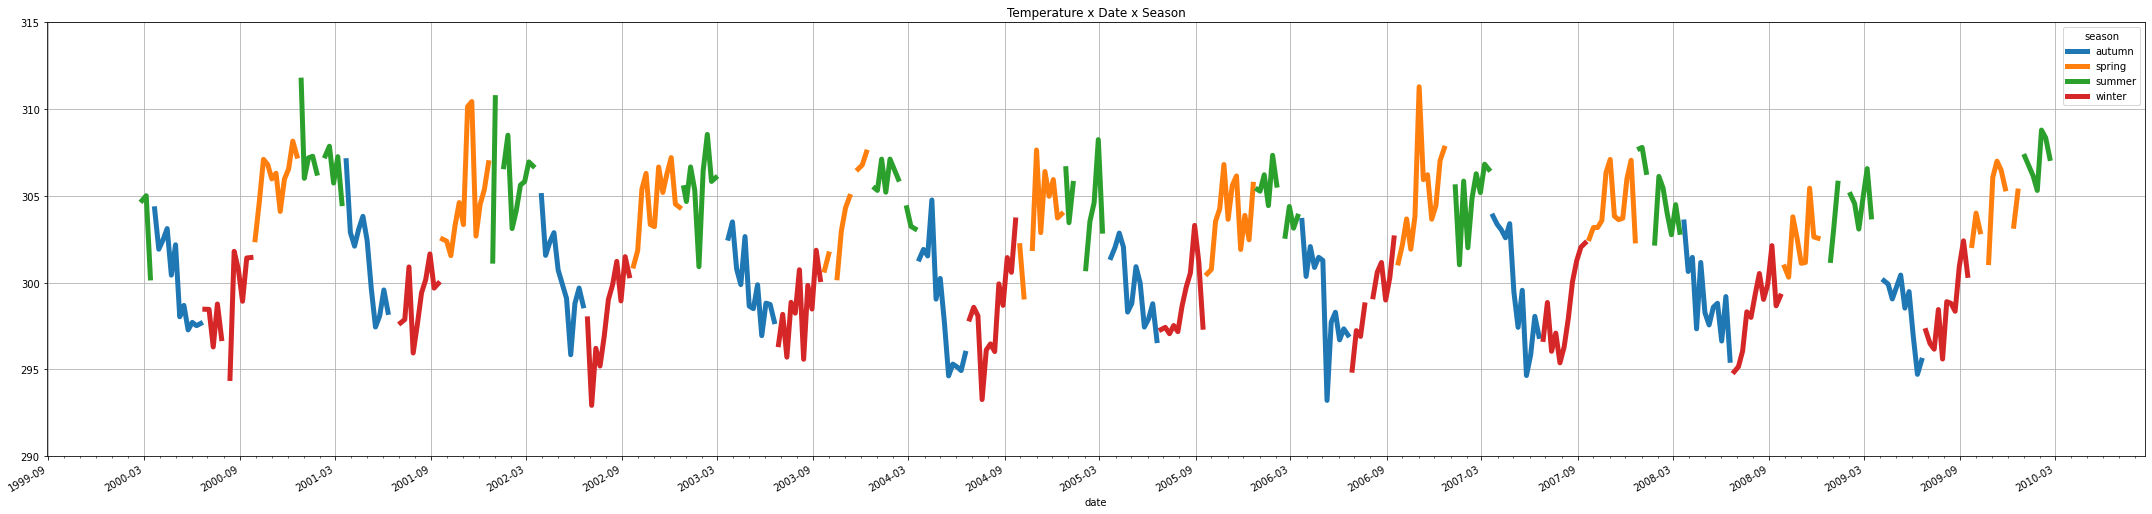

In [110]:
# finally, plot
plt.rcParams['figure.figsize'] = (30,8)

fig, ax3 = plt.subplots()

lststats_seasonal_all.reset_index().pivot('date','season','mean').plot(ax=ax3, title='Temperature x Date x Season', grid=True, linewidth=5)

plt.gca().set_ylim(290, 315)


# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax3.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax3.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()

plt.gcf().autofmt_xdate()